Import Libraries

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import numpy as np
import time

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm  # For a nice progress bar

# --- Evaluation Imports ---
from sklearn.metrics import classification_report

Setup Configuration & Load Data

In [29]:
# --- 1. SET PATHS ---
dataset_base_dir = r"/content/data/data"
train_path = os.path.join(dataset_base_dir, "train")
valid_path = os.path.join(dataset_base_dir, "valid")

# --- 2. DEFINE IMAGE SIZE AND BATCH SIZE ---
IMG_SIZE = 256
BATCH_SIZE = 128

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 3. PREPROCESSING (Augmentation & Normalization) ---
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transforms for the TRAINING set (with augmentation)
data_transforms_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Transforms for the VALIDATION set (no augmentation)
data_transforms_valid = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# --- 4. LOAD DATASETS ---
try:
    print(f"\nLoading training data from: {train_path}")
    train_dataset = datasets.ImageFolder(
        root=train_path,
        transform=data_transforms_train
    )

    print(f"Loading validation data from: {valid_path}")
    validation_dataset = datasets.ImageFolder(
        root=valid_path,
        transform=data_transforms_valid
    )

    class_names = train_dataset.classes
    print(f"\nSuccessfully loaded {len(class_names)} classes.")
    print("Example class names:", class_names[:5])

    # --- 5. IMPLEMENT DATA BALANCING (WeightedRandomSampler) ---
    print("\nCalculating class weights for data balancing...")

    train_labels = [label for _, label in train_dataset.samples]
    class_counts = pd.Series(train_labels).value_counts().sort_index()
    class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float)
    sample_weights = class_weights[train_labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    print("Class weights calculated and sampler is ready.")

    # --- 6. CREATE DATA LOADERS ---
    # Set num_workers=0 to avoid errors on Windows
    num_workers = 2
    print(f"Using {num_workers} workers for data loading.")

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True
    )

    validation_loader = DataLoader(
        dataset=validation_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print("\nData loading complete.")
    print("Variables 'train_loader' (balanced), 'validation_loader', 'device', and 'class_names' are ready.")

except Exception as e:
    print(f"\n--- An Error Occurred During Data Loading ---")
    print(f"Error: {e}")

Using device: cuda

Loading training data from: /content/data/data/train
Loading validation data from: /content/data/data/valid

Successfully loaded 38 classes.
Example class names: ['Apple Black Rot', 'Apple Cedar Rust', 'Apple Healthy', 'Apple Scab', 'Bell Pepper Bacterial Spot']

Calculating class weights for data balancing...
Class weights calculated and sampler is ready.
Using 2 workers for data loading.

Data loading complete.
Variables 'train_loader' (balanced), 'validation_loader', 'device', and 'class_names' are ready.


Exploratory Data Analysis (EDA)

Analyzing raw file distribution...

Found 38 classes in /content/data/data/train

Found 38 classes in /content/data/data/valid


/tmp/ipython-input-3029214451.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df.index, y=train_df['ImageCount'], ax=ax[0], palette='viridis')
/tmp/ipython-input-3029214451.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
/tmp/ipython-input-3029214451.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=valid_df.index, y=valid_df['ImageCount'], ax=ax[1], palette='plasma')
/tmp/ipython-input-3029214451.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

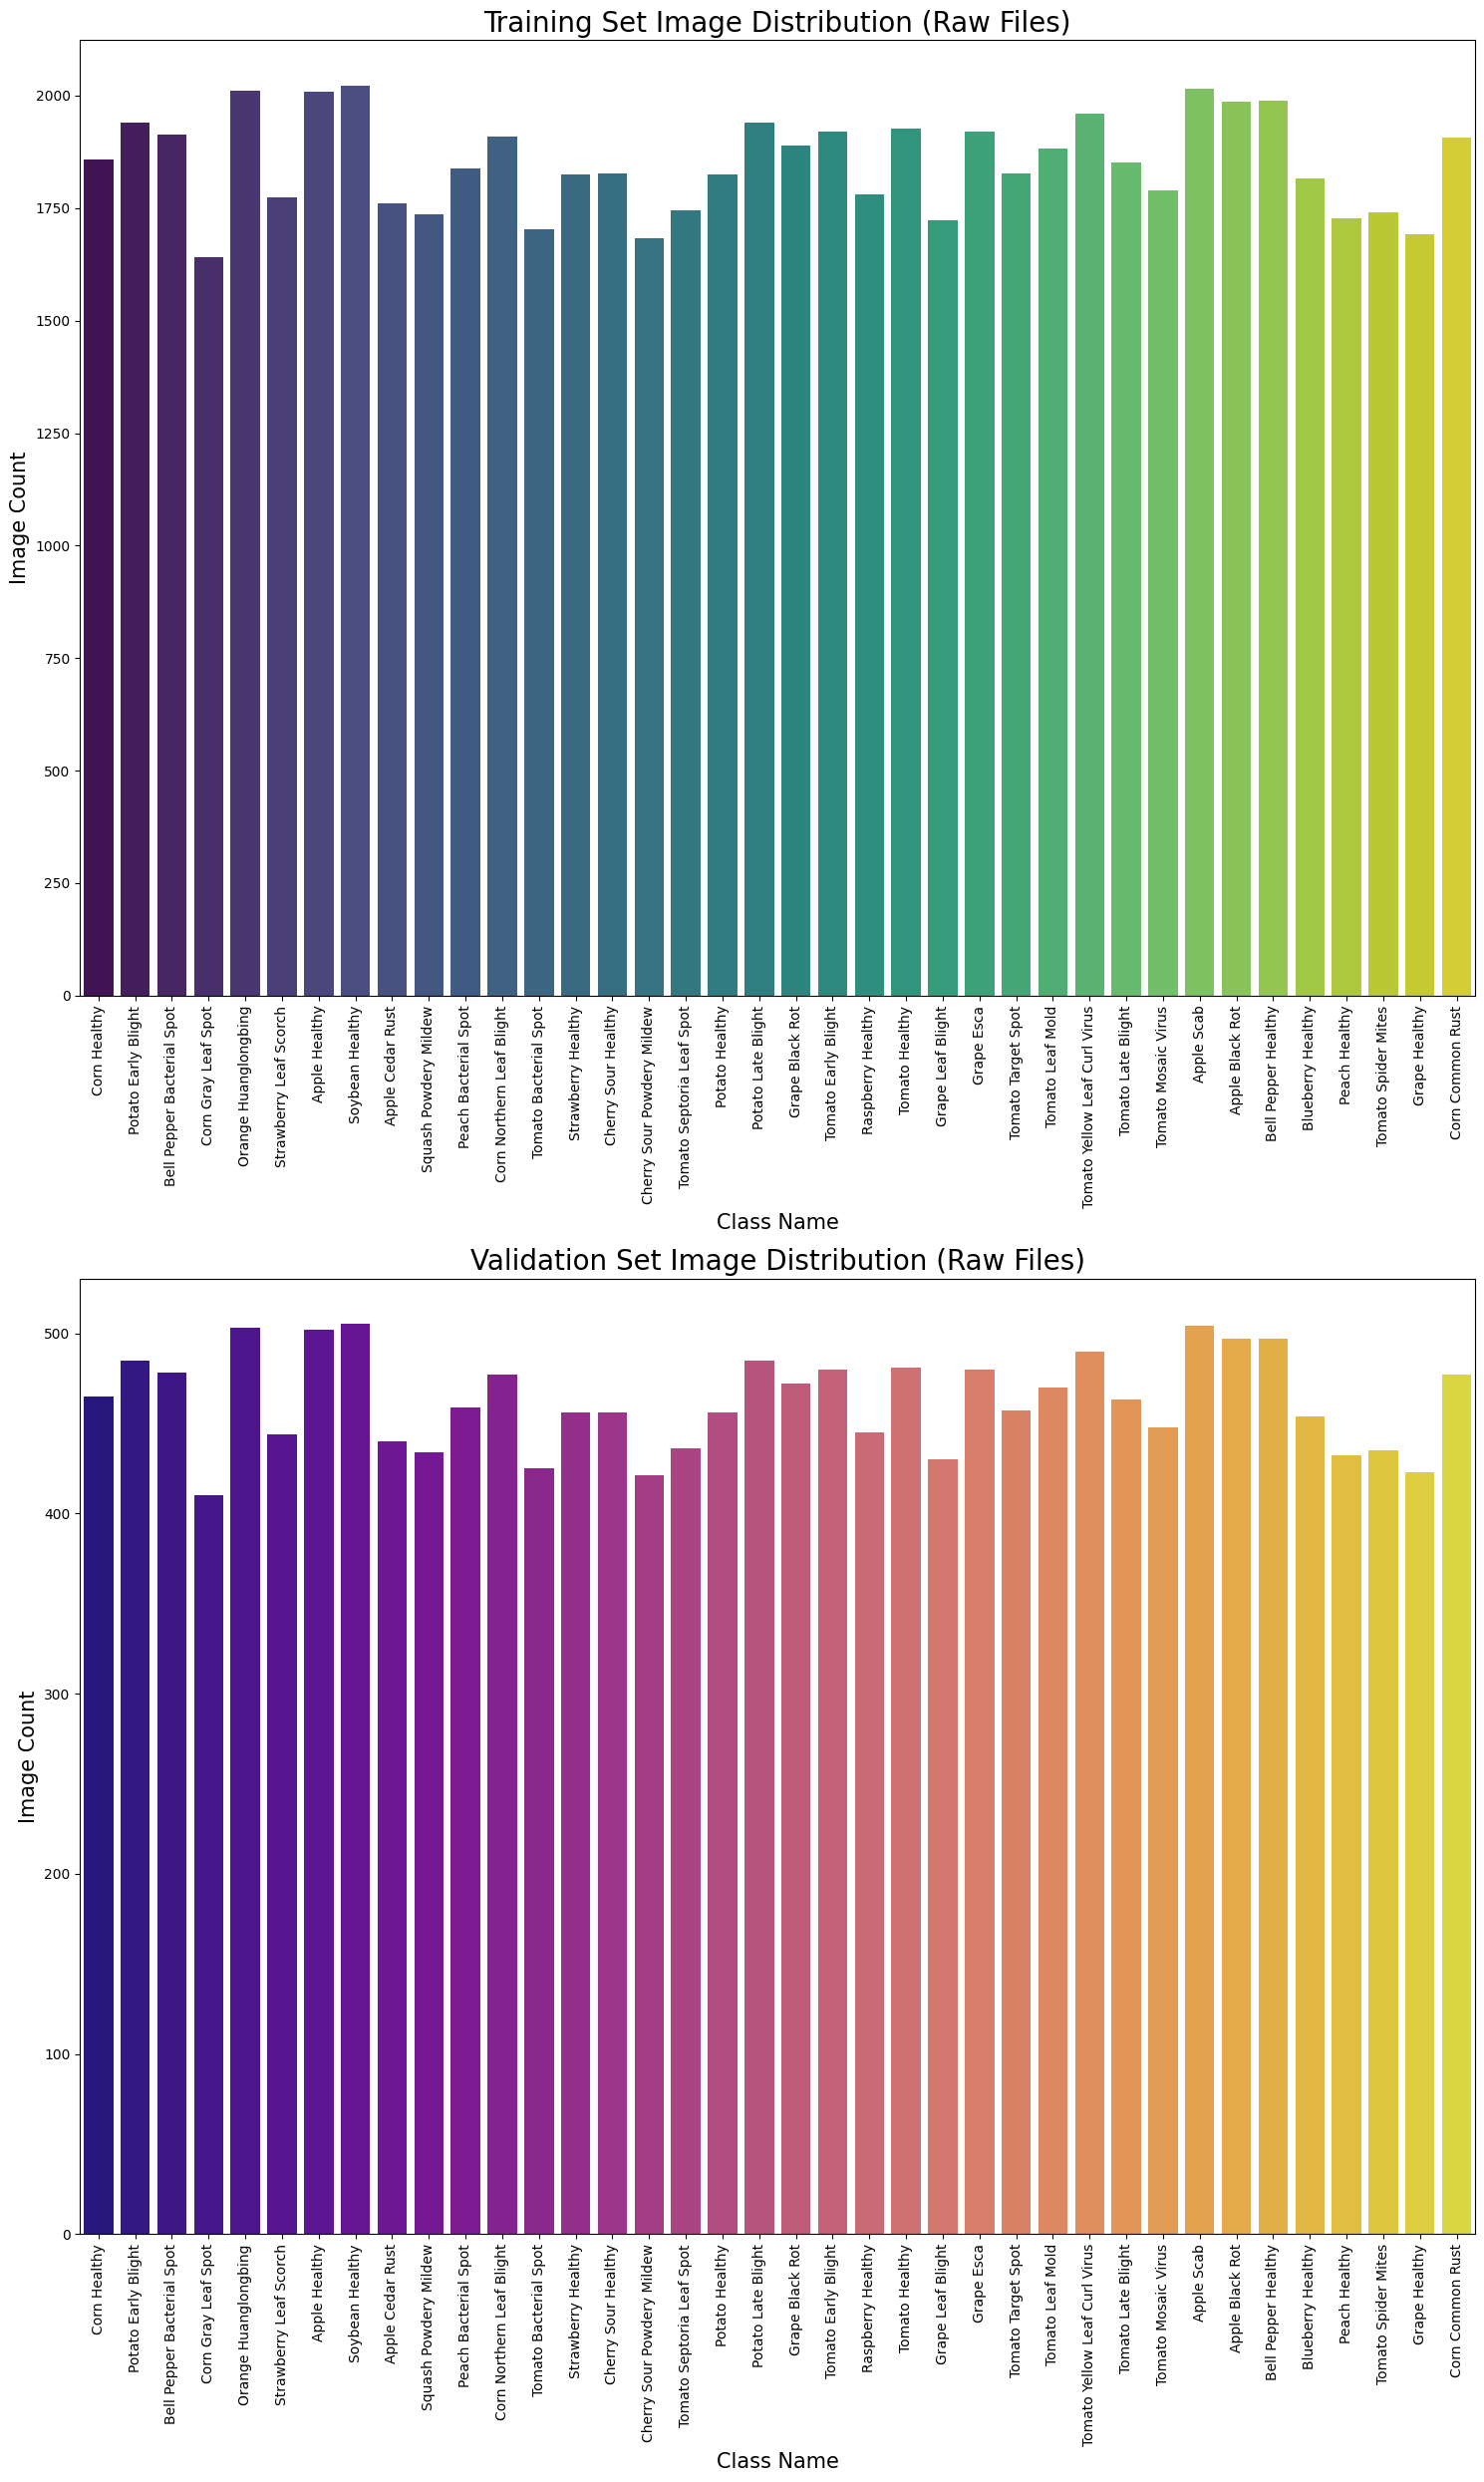


Displaying sample images...


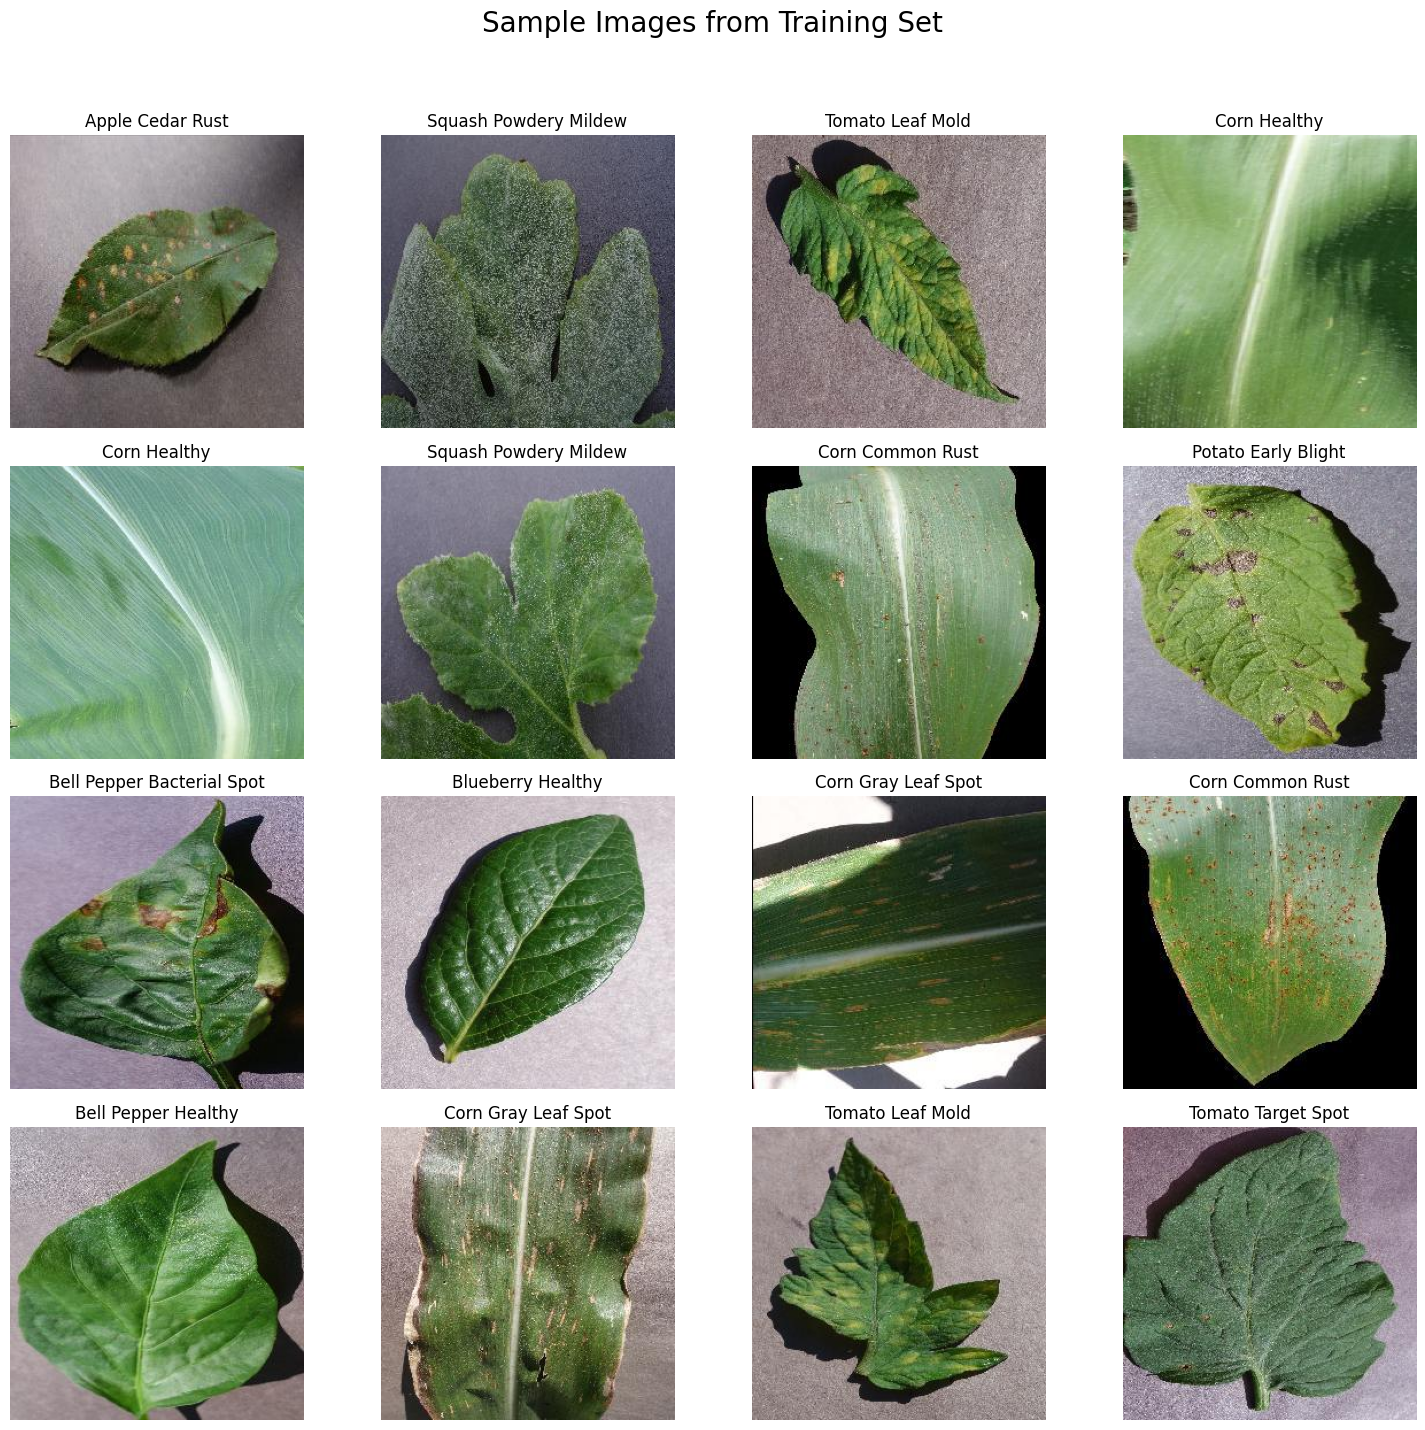

In [25]:
# --- 1. EDA FUNCTIONS ---

def get_class_distribution(data_dir):
    """Counts the number of images in each class subdirectory."""
    class_counts = {}
    try:
        class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    except FileNotFoundError:
        print(f"Error: Directory not found at {data_dir}")
        return None

    print(f"\nFound {len(class_names)} classes in {data_dir}")
    df = pd.DataFrame(columns=['Class', 'ImageCount'])
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_count = len(os.listdir(class_path))
        df.loc[len(df)] = [class_name, image_count]

    return df.set_index('Class')

def plot_class_distribution(train_df, valid_df):
    """Plots the image distribution for training and validation sets."""
    fig, ax = plt.subplots(2, 1, figsize=(15, 25))

    sns.barplot(x=train_df.index, y=train_df['ImageCount'], ax=ax[0], palette='viridis')
    ax[0].set_title('Training Set Image Distribution (Raw Files)', fontsize=20)
    ax[0].set_xlabel('Class Name', fontsize=15)
    ax[0].set_ylabel('Image Count', fontsize=15)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

    sns.barplot(x=valid_df.index, y=valid_df['ImageCount'], ax=ax[1], palette='plasma')
    ax[1].set_title('Validation Set Image Distribution (Raw Files)', fontsize=20)
    ax[1].set_xlabel('Class Name', fontsize=15)
    ax[1].set_ylabel('Image Count', fontsize=15)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

    plt.tight_layout()
    plt.show()

def visualize_samples(data_dir, class_names_list, num_samples=16):
    """Displays a grid of random sample images from the dataset."""
    plt.figure(figsize=(15, 15))
    grid_size = int(np.ceil(num_samples**0.5))

    for i in range(num_samples):
        plt.subplot(grid_size, grid_size, i + 1)

        random_class = random.choice(class_names_list)
        class_path = os.path.join(data_dir, random_class)

        random_image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, random_image_name)

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

        plt.imshow(img)
        plt.title(random_class)
        plt.axis('off')

    plt.suptitle('Sample Images from Training Set', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 2. RUN EDA ---
print("Analyzing raw file distribution...")
train_df = get_class_distribution(train_path)
valid_df = get_class_distribution(valid_path)

if train_df is not None and valid_df is not None:
    plot_class_distribution(train_df, valid_df)

print("\nDisplaying sample images...")
visualize_samples(train_path, class_names)

Verify Data Balancing

--- Checking Balanced Batch Distribution ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Inspected 12800 total images across 100 batches.


/tmp/ipython-input-2440997780.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


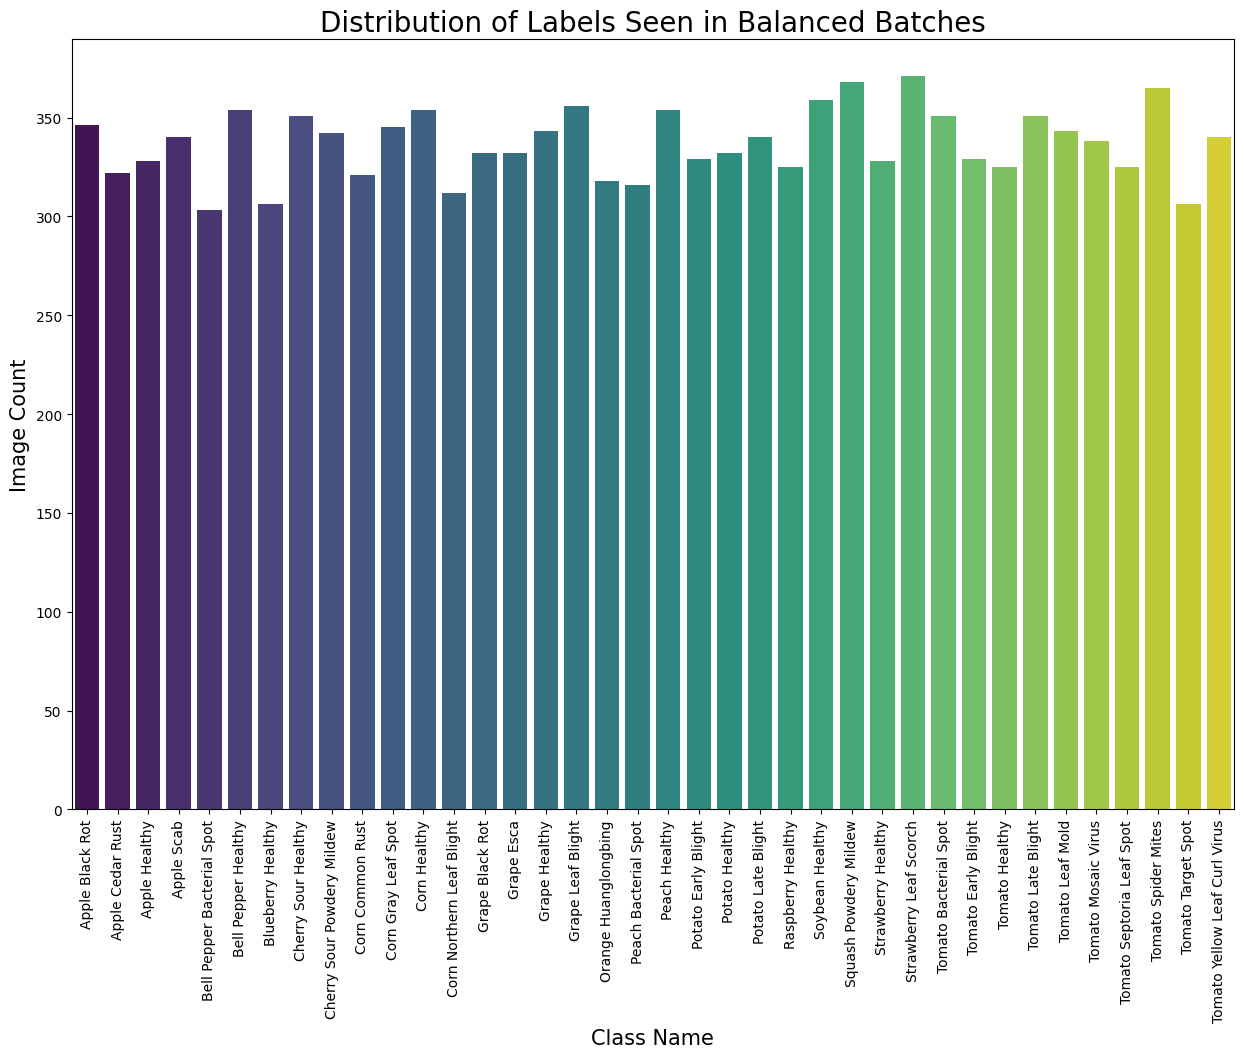

In [26]:
print("--- Checking Balanced Batch Distribution ---")
labels_seen = []
loader_iter = iter(train_loader)

# Check 100 batches
for i in range(100):
    try:
        _, labels = next(loader_iter)
        labels_seen.extend(labels.numpy().tolist())
    except StopIteration:
        break

print(f"Inspected {len(labels_seen)} total images across 100 batches.")

# --- Count and Plot ---
label_counts = pd.Series(labels_seen).value_counts()
label_counts.index = [class_names[i] for i in label_counts.index]
label_counts = label_counts.sort_index()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Labels Seen in Balanced Batches', fontsize=20)
plt.xlabel('Class Name', fontsize=15)
plt.ylabel('Image Count', fontsize=15)
plt.xticks(rotation=90)
plt.show()

Model Definition

In [27]:
# Get the number of classes from the loaded dataset
num_classes = len(class_names)
print(f"Model will be trained for {num_classes} classes.")

# Load a pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the final layer
num_ftrs = model.fc.in_features

# Replace the final layer
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the GPU
model = model.to(device)

print("\nModel definition complete.")
print(model) # Uncomment to see the model architecture

Model will be trained for 38 classes.

Model definition complete.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequen

Model Training

In [30]:
# --- 1. DEFINE LOSS FUNCTION AND OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# --- 2. DEFINE TRAINING & VALIDATION FUNCTIONS ---

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Runs a single training epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc="Training", unit="batch")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        progress_bar.set_postfix(loss=(running_loss / total_samples),
                                 acc=(correct_predictions.double() / total_samples).item())

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples).item()
    return epoch_loss, epoch_acc

def validate_one_epoch(model, validation_loader, criterion, device):
    """Runs a single validation epoch."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        progress_bar = tqdm(validation_loader, desc="Validating", unit="batch")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            progress_bar.set_postfix(loss=(running_loss / total_samples),
                                     acc=(correct_predictions.double() / total_samples).item())

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples).item()
    return epoch_loss, epoch_acc

# --- 3. RUN THE TRAINING LOOP ---
NUM_EPOCHS = 10
best_val_acc = 0.0
model_save_path = "plant_disease_resnet50_best.pth"

print("\n--- Starting Model Training ---")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 20)

    start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, validation_loader, criterion, device)

    epoch_duration = time.time() - start_time

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Time: {epoch_duration:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {val_loss:.4f} | Valid Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"  ** New best model saved to {model_save_path} (Acc: {best_val_acc:.4f}) **")

print("\n--- Training Complete ---")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best model weights saved to {model_save_path}")


--- Starting Model Training ---

Epoch 1/10
--------------------


Validating: 100%|██████████| 138/138 [01:02<00:00,  2.21batch/s, acc=0.939, loss=0.347]



Epoch 1 Summary:
  Time: 738.34s
  Train Loss: 0.6373 | Train Acc: 0.8982
  Valid Loss: 0.3466 | Valid Acc: 0.9394
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9394) **

Epoch 2/10
--------------------


Validating: 100%|██████████| 138/138 [01:01<00:00,  2.23batch/s, acc=0.958, loss=0.211]



Epoch 2 Summary:
  Time: 734.15s
  Train Loss: 0.2586 | Train Acc: 0.9467
  Valid Loss: 0.2110 | Valid Acc: 0.9577
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9577) **

Epoch 3/10
--------------------


Validating: 100%|██████████| 138/138 [01:01<00:00,  2.23batch/s, acc=0.964, loss=0.168]



Epoch 3 Summary:
  Time: 724.07s
  Train Loss: 0.1888 | Train Acc: 0.9563
  Valid Loss: 0.1685 | Valid Acc: 0.9638
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9638) **

Epoch 4/10
--------------------


Validating: 100%|██████████| 138/138 [01:02<00:00,  2.22batch/s, acc=0.967, loss=0.146]



Epoch 4 Summary:
  Time: 716.57s
  Train Loss: 0.1544 | Train Acc: 0.9640
  Valid Loss: 0.1458 | Valid Acc: 0.9671
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9671) **

Epoch 5/10
--------------------


Validating: 100%|██████████| 138/138 [01:02<00:00,  2.22batch/s, acc=0.971, loss=0.123]



Epoch 5 Summary:
  Time: 714.10s
  Train Loss: 0.1306 | Train Acc: 0.9690
  Valid Loss: 0.1234 | Valid Acc: 0.9706
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9706) **

Epoch 6/10
--------------------


Validating: 100%|██████████| 138/138 [01:02<00:00,  2.22batch/s, acc=0.971, loss=0.115]



Epoch 6 Summary:
  Time: 718.20s
  Train Loss: 0.1144 | Train Acc: 0.9720
  Valid Loss: 0.1152 | Valid Acc: 0.9711
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9711) **

Epoch 7/10
--------------------


Validating: 100%|██████████| 138/138 [01:01<00:00,  2.23batch/s, acc=0.974, loss=0.101]



Epoch 7 Summary:
  Time: 713.87s
  Train Loss: 0.1031 | Train Acc: 0.9740
  Valid Loss: 0.1007 | Valid Acc: 0.9739
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9739) **

Epoch 8/10
--------------------


Validating: 100%|██████████| 138/138 [01:02<00:00,  2.21batch/s, acc=0.976, loss=0.0953]



Epoch 8 Summary:
  Time: 712.03s
  Train Loss: 0.0960 | Train Acc: 0.9754
  Valid Loss: 0.0953 | Valid Acc: 0.9759
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9759) **

Epoch 9/10
--------------------


Validating: 100%|██████████| 138/138 [01:01<00:00,  2.23batch/s, acc=0.977, loss=0.0877]



Epoch 9 Summary:
  Time: 711.44s
  Train Loss: 0.0906 | Train Acc: 0.9755
  Valid Loss: 0.0877 | Valid Acc: 0.9767
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9767) **

Epoch 10/10
--------------------


Validating: 100%|██████████| 138/138 [01:02<00:00,  2.22batch/s, acc=0.977, loss=0.0836]



Epoch 10 Summary:
  Time: 714.30s
  Train Loss: 0.0842 | Train Acc: 0.9776
  Valid Loss: 0.0836 | Valid Acc: 0.9770
  ** New best model saved to plant_disease_resnet50_best.pth (Acc: 0.9770) **

--- Training Complete ---
Best Validation Accuracy: 0.9770
Best model weights saved to plant_disease_resnet50_best.pth


Model Evaluation

In [31]:
print(f"Loading best model from: {model_save_path}")

# --- 1. RE-CREATE THE MODEL ARCHITECTURE ---
eval_model = models.resnet50()
num_ftrs = eval_model.fc.in_features
eval_model.fc = nn.Linear(num_ftrs, num_classes)

# --- 2. LOAD THE SAVED WEIGHTS ---
try:
    eval_model.load_state_dict(torch.load(model_save_path))
except Exception as e:
    print(f"Error loading model weights: {e}")
    # Handle the error appropriately

eval_model = eval_model.to(device)
eval_model.eval()

# --- 3. GET PREDICTIONS FOR ALL VALIDATION DATA ---
print("Running final evaluation on validation data...")

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in tqdm(validation_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = eval_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())

# --- 4. SHOW THE CLASSIFICATION REPORT ---
print("\n--- Evaluation Report ---")

report = classification_report(
    all_labels,
    all_predictions,
    target_names=class_names,
    zero_division=0
)

print(report)

Loading best model from: plant_disease_resnet50_best.pth
Running final evaluation on validation data...


Evaluating: 100%|██████████| 138/138 [01:01<00:00,  2.23it/s]


--- Evaluation Report ---
                               precision    recall  f1-score   support

              Apple Black Rot       0.99      1.00      0.99       497
             Apple Cedar Rust       0.99      1.00      0.99       440
                Apple Healthy       1.00      0.98      0.99       502
                   Apple Scab       0.99      0.98      0.99       504
   Bell Pepper Bacterial Spot       1.00      0.97      0.98       478
          Bell Pepper Healthy       0.97      1.00      0.98       497
            Blueberry Healthy       0.99      1.00      0.99       454
          Cherry Sour Healthy       0.99      1.00      0.99       456
   Cherry Sour Powdery Mildew       1.00      1.00      1.00       421
             Corn Common Rust       1.00      1.00      1.00       477
          Corn Gray Leaf Spot       0.95      0.91      0.93       410
                 Corn Healthy       1.00      1.00      1.00       465
    Corn Northern Leaf Blight       0.92      0.9

Confusion Matrix

--- Displaying Confusion Matrix ---


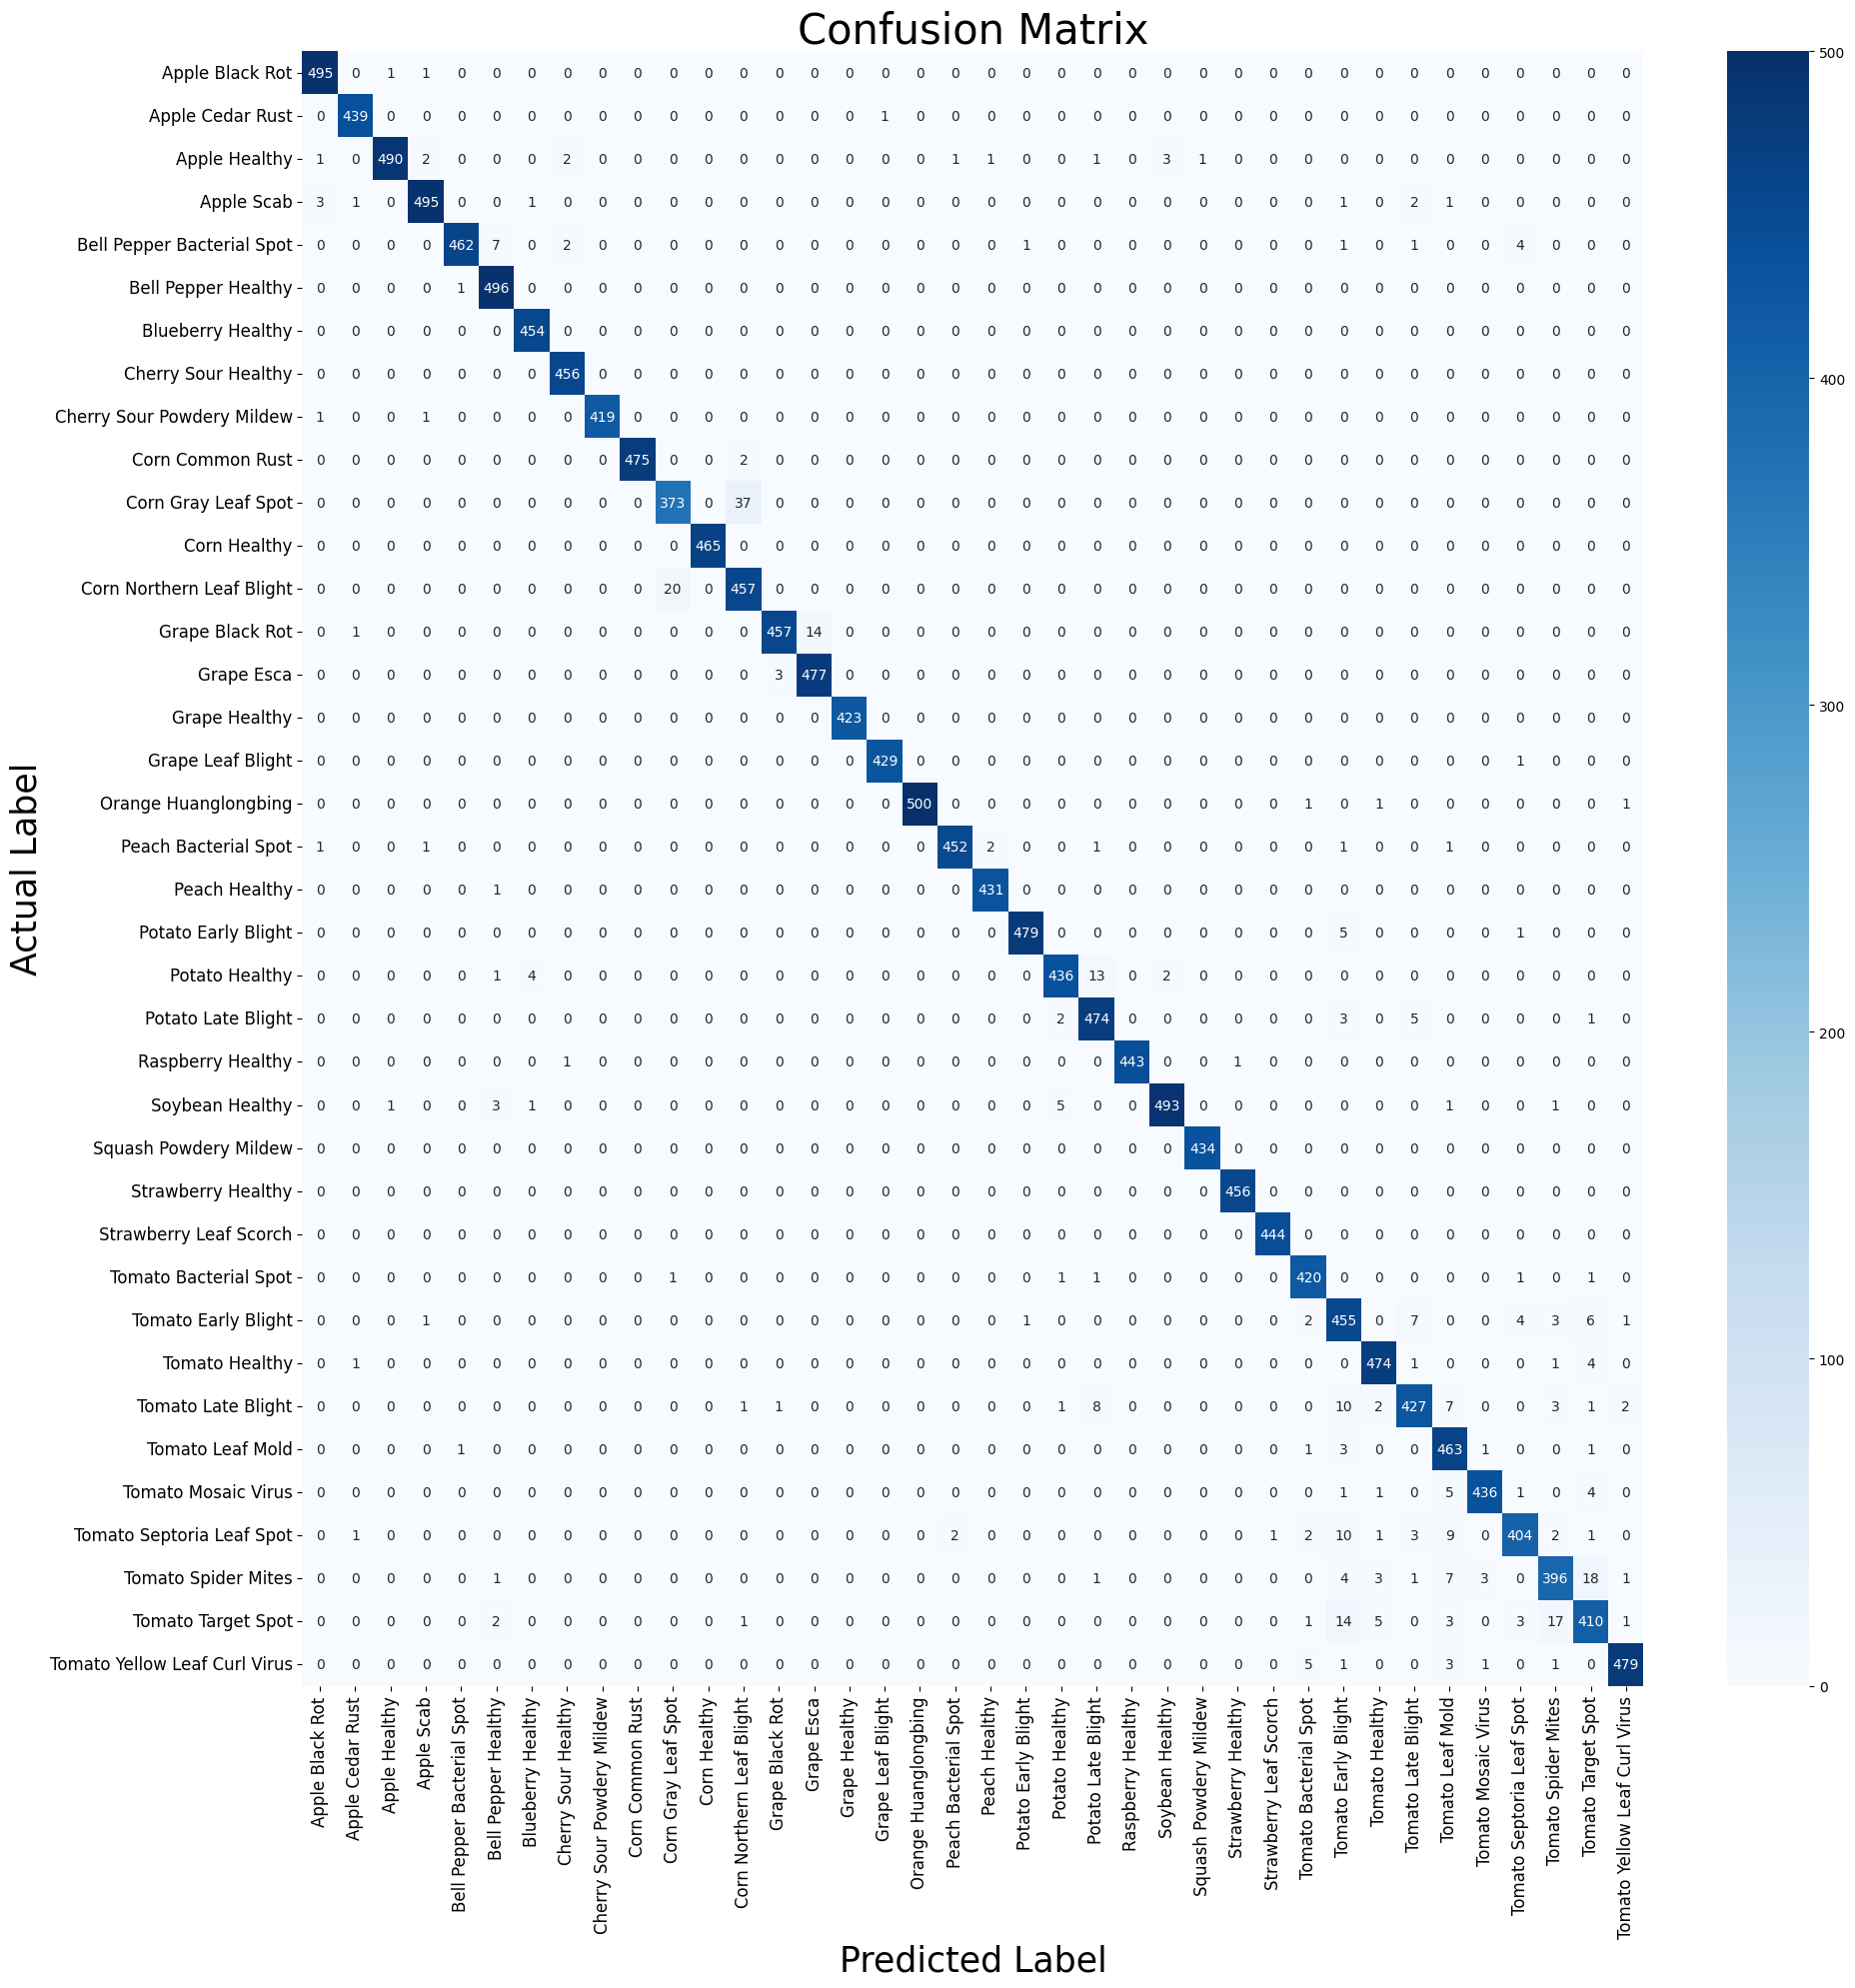

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# We already have all_labels and all_predictions from the previous cell

# 1. Generate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# 2. Create a function to plot it as a heatmap
def plot_confusion_matrix(cm, class_names):
    """
    Renders a beautified confusion matrix heatmap.
    """
    plt.figure(figsize=(20, 20))  # Set the figure size

    # Create the heatmap
    sns.heatmap(
        cm,
        annot=True,     # Annotate cells with the counts
        fmt='d',        # Format annotations as integers
        cmap='Blues',   # Color map
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.title('Confusion Matrix', fontsize=30)
    plt.ylabel('Actual Label', fontsize=25)
    plt.xlabel('Predicted Label', fontsize=25)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

# 3. Plot the matrix
print("--- Displaying Confusion Matrix ---")
plot_confusion_matrix(cm, class_names)

Export Your Model Assets

In [33]:
import json

# This variable should be in your notebook's memory from the data loading cell
# (Cell 2 in our organized notebook)
if 'class_names' not in globals():
    print("Error: 'class_names' variable not found.")
    print("Please re-run your data loading cell (Cell 2) to create it.")
else:
    # Define the file path for the class names
    class_names_path = "class_names.json"

    # Write the class_names list to the JSON file
    with open(class_names_path, 'w') as f:
        json.dump(class_names, f)

    print(f"--- Model Assets Exported ---")
    print(f"1. Model Weights: {model_save_path}")  # This file was saved by your training cell
    print(f"2. Class Names:   {class_names_path}")
    print("\nThese two files are all you need to load and use your model elsewhere.")

--- Model Assets Exported ---
1. Model Weights: plant_disease_resnet50_best.pth
2. Class Names:   class_names.json

These two files are all you need to load and use your model elsewhere.
